In [13]:
operational_metrics = ['model_size_mb', 'avg_time_ms', 'mae', 'mape', 'build_time_s']
small_datasets = set(["zcta5", "aerowaythingnodesorted", "craftwaysorted", "arealm", "emergencythingwaysorted", "historicthingwaysorted", "aerowaythingwaysorted"])
big_datasets = set(['powerthingnodesorted', 'yago2', 'powerthingwaysorted', 'barrierthingwaysorted', 'cyclewaythingwaysorted', 'areawater', 'leisurewaysorted'])

# Subfigures (3 filters in 1 -> all)

In [14]:
import os   
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from matplotlib.patches import Polygon
from IPython.display import display

def plot_method_radar_comparison_filters(json_path, operational_metrics, figsize=(15, 12), 
                                       title=None, save_path=None, metric_display_names=None,
                                       normalization_method='mad', datasets_to_exclude=set([])):
    """
    Create radar charts comparing methods across operational metrics with robust scaling,
    creating a separate subfigure for each filter.
    
    Args:
        json_path: Path to JSON file containing performance metrics
        operational_metrics: List of metrics to use as radar axes (e.g., ['build_time_s', 'model_size_mb'])
        figsize: Figure size for the entire figure
        title: Custom title
        save_path: Path to save the figure
        metric_display_names: Dictionary mapping metric names to display names
        normalization_method: Method for normalizing values ('mad', 'minmax', or 'zscore')
        
    Returns:
        matplotlib Figure and list of Axes
    """
    # Validate normalization method
    if normalization_method not in ['mad', 'minmax', 'zscore']:
        raise ValueError("normalization_method must be one of: 'mad', 'minmax', 'zscore'")
    
    # Define which metrics have "smaller is better" property
    smaller_is_better = {
        'build_time_s': True,
        'avg_time_ms': True,
        'model_size_mb': True,
        'mae': True, 
        'mape': True,
    }
    
    # Define display names if not provided (with MAE and MAPE shown as x10^3)
    if metric_display_names is None:
        metric_display_names = {
            'build_time_s': 'Build Time (s)',
            'avg_time_ms': 'Prediction Time (ms)',
            'model_size_mb': 'Model Size (MB)',
            'mae': 'MAE (×10³)',
            'mape': 'MAPE (×10³)',
        }
    
    # Fill in any missing display names
    for metric in operational_metrics:
        if metric not in metric_display_names:
            metric_display_names[metric] = metric
    
    # Load the JSON data
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Reorganize data by filter then by model
    filters_data = {}
    
    # Process all datasets
    for dataset, models in data.items():
        if dataset in datasets_to_exclude:
            continue
        for model, filters in models.items():
            if model == 'DT':
                continue
            for filter_name, metrics in filters.items():
                if filter_name not in filters_data:
                    filters_data[filter_name] = {}
                
                if model not in filters_data[filter_name]:
                    filters_data[filter_name][model] = {metric: [] for metric in operational_metrics}
                
                # Collect metrics for this model and filter
                for metric in operational_metrics:
                    if metric in metrics:
                        filters_data[filter_name][model][metric].append(metrics[metric])
    
    # Calculate average metrics for each filter and model
    filter_model_metrics = {}
    
    for filter_name, models in filters_data.items():
        filter_model_metrics[filter_name] = {}
        
        for model, metrics in models.items():
            filter_model_metrics[filter_name][model] = {}
            
            for metric, values in metrics.items():
                if values:  # Check if there are any values
                    filter_model_metrics[filter_name][model][metric] = np.mean(values)
                else:
                    filter_model_metrics[filter_name][model][metric] = np.nan
    
    # Get all filters and models
    all_filters = list(filter_model_metrics.keys())
    
    # Get all unique models across all filters for the legend
    all_models = set()
    for filter_data in filter_model_metrics.values():
        all_models.update(filter_data.keys())
    all_models = list(all_models)
    
    # Determine subplot grid dimensions
    n_filters = len(all_filters)
    n_cols = min(3, n_filters)  # Max 3 columns
    n_rows = (n_filters + n_cols - 1) // n_cols  # Ceiling division
    
    # Create figure with subfigures
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, 
                            subplot_kw={'polar': False})
    
    # Flatten axes array for easier indexing
    if n_filters == 1:
        axes = np.array([axes])
    axes_flat = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]
    
    # Create color palette for all models
    palette = sns.color_palette('tab10', n_colors=len(all_models))
    model_colors = {model: palette[i] for i, model in enumerate(all_models)}
    
    # Store legend handles
    legend_handles = []
    legend_labels = []
    
    # Process each filter
    for i, filter_name in enumerate(all_filters):
        if i < len(axes_flat):
            ax = axes_flat[i]
            
            # Get data for this filter
            models_data = filter_model_metrics[filter_name]
            
            # Convert to DataFrame
            data_df = pd.DataFrame.from_dict(models_data, orient='index')
            raw_data = models_data.copy()
            
            # Store normalization info for this filter
            normalization_info = {}
            
            # Normalize each metric
            normalized_df = data_df.copy()
            
            for metric in operational_metrics:
                # Skip if metric not present
                if metric not in data_df.columns:
                    continue
                
                # Get metric values
                values = data_df[metric].values
                
                # Skip if only one distinct value or all NaN
                if len(np.unique(values[~np.isnan(values)])) <= 1:
                    normalized_df[metric] = 0.5
                    # Store min/max as same value for inverse mapping
                    normalization_info[metric] = {
                        'type': 'constant',
                        'value': values[~np.isnan(values)][0] if any(~np.isnan(values)) else 0
                    }
                    continue
                
                # Handle NaNs by replacing with the mean
                if np.any(np.isnan(values)):
                    mean_val = np.nanmean(values)
                    values = np.nan_to_num(values, nan=mean_val)
                    data_df[metric] = values  # Update DataFrame
                
                # Store min/max for this metric
                min_val = np.min(values)
                max_val = np.max(values)
                
                if normalization_method == 'mad':
                    # Use robust scaling with median absolute deviation
                    median_val = np.median(values)
                    mad = np.median(np.abs(values - median_val))
                    
                    if mad > 0:
                        # Scale using MAD
                        normalized = (values - median_val) / (1.4826 * mad)
                        
                        # Convert to 0-1 range using sigmoid function
                        normalized = 1 / (1 + np.exp(-normalized))
                        
                        # Store normalization parameters
                        normalization_info[metric] = {
                            'type': 'mad_sigmoid',
                            'median': median_val,
                            'mad': mad
                        }
                    else:
                        # If MAD is 0, fall back to min-max scaling
                        if max_val > min_val:
                            normalized = (values - min_val) / (max_val - min_val)
                        else:
                            normalized = np.ones_like(values) * 0.5
                            
                        # Store normalization parameters
                        normalization_info[metric] = {
                            'type': 'minmax',
                            'min': min_val,
                            'max': max_val
                        }
                        
                elif normalization_method == 'minmax':
                    # Use min-max scaling
                    if max_val > min_val:
                        normalized = (values - min_val) / (max_val - min_val)
                    else:
                        normalized = np.ones_like(values) * 0.5
                        
                    # Store normalization parameters
                    normalization_info[metric] = {
                        'type': 'minmax',
                        'min': min_val,
                        'max': max_val
                    }
                        
                elif normalization_method == 'zscore':
                    # Use Z-score normalization
                    mean_val = np.mean(values)
                    std_val = np.std(values)
                    
                    if std_val > 0:
                        # Z-score: (x - μ) / σ
                        z_scores = (values - mean_val) / std_val
                        
                        # Convert to 0-1 range using sigmoid function
                        normalized = 1 / (1 + np.exp(-z_scores))
                        
                        # Store normalization parameters
                        normalization_info[metric] = {
                            'type': 'zscore_sigmoid',
                            'mean': mean_val,
                            'std': std_val
                        }
                    else:
                        # If std is 0, all values are the same
                        normalized = np.ones_like(values) * 0.5
                        print(f"Warning: Standard deviation is 0 for metric '{metric}', using constant value.")
                        
                        # Store normalization parameters
                        normalization_info[metric] = {
                            'type': 'constant',
                            'value': mean_val
                        }
                
                normalized_df[metric] = normalized

            print(f"Filter '{filter_name}':")
            display(data_df)
            
            # Number of metrics (angles/axes)
            N = len(operational_metrics)
            
            # Angles for each metric (in radians)
            angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
            
            # Create labels with direction indicators (↑/↓) and display names
            labels = []
            for metric in operational_metrics:
                display_name = metric_display_names[metric]
                if smaller_is_better.get(metric, True):
                    labels.append(f"{display_name}")  # Down arrow for "smaller is better"
                else:
                    labels.append(f"{display_name}")  # Up arrow for "bigger is better"
            
            # Convert to cartesian coordinates
            def polar_to_cartesian(r, theta):
                return r * np.cos(theta), r * np.sin(theta)
            
            # Define grid levels in normalized space
            grid_levels = [0.25, 0.5, 0.75, 1.0]
            
            # Draw grid polygons
            for level in grid_levels:
                # Get points on polygon for this level
                polygon_coords = []
                for angle in angles:
                    x, y = polar_to_cartesian(level, angle)
                    polygon_coords.append((x, y))
                
                # Create and plot the polygon
                poly = Polygon(polygon_coords, closed=True, fill=False, 
                              edgecolor='gray', linewidth=0.5, alpha=0.7)
                ax.add_patch(poly)
                
                # Add text label for the grid level at the first axis
                if level > 0:  # Skip the center point
                    label_x, label_y = polar_to_cartesian(level, angles[0])
                    # Position text slightly to the right of the axis
                    text_x = label_x + 0.03
                    text_y = label_y
                    ax.text(text_x, text_y, f"{level:.1f}", 
                            ha='left', va='center', fontsize=7, color='gray')
            
            # Draw radial lines from center to each metric
            for j, angle in enumerate(angles):
                metric = operational_metrics[j % len(operational_metrics)]  # Ensure we don't go out of bounds
                x_end, y_end = polar_to_cartesian(1.0, angle)
                ax.plot([0, x_end], [0, y_end], '-', color='gray', linewidth=0.5, alpha=0.7)
                
                # Position the metric labels slightly outside the polygon
                label_x, label_y = polar_to_cartesian(1.15, angle)
                ha = 'left' if label_x >= 0 else 'right'
                va = 'center'
                # Adjust for labels near the top or bottom
                if abs(label_y) > 0.85:
                    va = 'top' if label_y < 0 else 'bottom'
                    ha = 'center'
                
                ax.text(label_x, label_y, labels[j % len(labels)], ha=ha, va=va, fontsize=10, weight='bold')
            
            # Add colored lines for each model
            models = list(models_data.keys())
            
            for j, model in enumerate(models):
                if model not in data_df.index:
                    continue
                    
                color = model_colors[model]
                
                # Get normalized values and convert to cartesian coordinates
                values = []
                for metric in operational_metrics:
                    if metric in normalized_df.columns and model in normalized_df.index:
                        values.append(normalized_df.loc[model, metric])
                    else:
                        values.append(np.nan)
                
                polygon_coords = []
                data_points = []
                
                for k, angle in enumerate(angles):
                    if k >= len(values):
                        continue
                        
                    metric = operational_metrics[k]
                    norm_value = values[k]
                    
                    if np.isnan(norm_value):
                        continue
                        
                    raw_value = data_df.loc[model, metric]
                    
                    # Scale MAE and MAPE by 1000 for display
                    display_value = raw_value
                    if metric in ['mae', 'mape']:
                        display_value = raw_value / 1000
                    
                    x, y = polar_to_cartesian(norm_value, angle)
                    polygon_coords.append((x, y))
                    data_points.append((x, y, display_value, angle, metric))
                
                if polygon_coords:
                    # Create and plot the polygon for this method
                    poly = Polygon(polygon_coords, closed=True, alpha=0.1, 
                                  edgecolor=color, facecolor=color, linewidth=2)
                    ax.add_patch(poly)
                    
                    # Plot the polygon vertices
                    xs = [p[0] for p in polygon_coords]
                    ys = [p[1] for p in polygon_coords]
                    
                    # If we have enough points to close the polygon
                    if len(xs) > 2:
                        xs.append(xs[0])  # Close the polygon
                        ys.append(ys[0])
                    
                    # Plot the line
                    line = ax.plot(xs, ys, '-', color=color, linewidth=2)
                    
                    # Save the legend handle only once (from the first filter)
                    if i == 0:
                        legend_handles.append(line[0])
                        legend_labels.append(model if model != 'NN' else 'MLP')
                    
                    # Add data point markers
                    for x, y, display_value, angle, metric in data_points:
                        ax.plot(x, y, 'o', color=color, markersize=5)
                        
                        # Format the value based on its magnitude and metric
                        if abs(display_value) < 0.01 or abs(display_value) > 1000:
                            value_text = f"{display_value:.2e}"
                        else:
                            value_text = f"{display_value:.3g}"
                        
                        # Position the text based on the angle
                        # Adjust position to prevent overlap
                        offset = 0.07
                        perp_angle = angle + np.pi/2  # Perpendicular to the radial line
                        
                        # Text position with offset perpendicular to radial line
                        text_x = x + offset * np.cos(perp_angle)
                        text_y = y + offset * np.sin(perp_angle)
                        
                        # Adjust alignment based on position in the chart
                        ha = 'center'
                        va = 'center'
                        if abs(np.cos(angle)) > 0.7:  # Near horizontal axes
                            va = 'bottom' if np.cos(angle) < 0 else 'top'
                        if abs(np.sin(angle)) > 0.7:  # Near vertical axes
                            ha = 'right' if np.sin(angle) < 0 else 'left'
                        
                        # Add the value text with faint background for readability
                        ax.text(text_x, text_y, value_text,
                               ha=ha, va=va, fontsize=4, color=color,
                               bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
            
            # Equal aspect ratio ensures the polygon looks regular
            ax.set_aspect('equal')
            
            # Remove the axis ticks and spines
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_visible(False)
            
            # Set limits slightly larger than the outermost grid level
            ax.set_xlim(-1.2, 1.2)
            ax.set_ylim(-1.2, 1.2)
            
            # Add filter name as subplot title
            ax.set_title(f"Filter: {filter_name}", fontsize=14)
    
    # Hide unused subplots
    for j in range(n_filters, len(axes_flat)):
        axes_flat[j].set_visible(False)
    
    # Add a single legend for the entire figure
    if legend_handles:
        fig.legend(legend_handles, legend_labels, 
                  loc='lower center', ncol=min(len(legend_labels), 4),
                  bbox_to_anchor=(0.5, 0.01), fontsize=12)
    
    # Set overall figure title
    if title is None:
        norm_name_map = {
            "mad": "MAD",
            "minmax": "Min-Max",
            "zscore": "Z-Score"
        }
        norm_name = norm_name_map.get(normalization_method, normalization_method.capitalize())
        # title = f"Model Performance by Filter ({norm_name} scaling)"
    
    fig.suptitle(title, fontsize=16, y=0.98)
    
    # Adjust layout to make room for the legend at the bottom
    plt.tight_layout(rect=[0, 0.05, 1, 0.96])
    
    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig, axes

## Small datasets & All filters

Filter 'intersect':


,model_size_mb,avg_time_ms,mae,mape,build_time_s
Histogram,0.521394,0.048736,391.428077,32.676672,1.857214
RTree,43.517480,0.013745,2574.830526,7.066241,41.076780
KNN,7.344122,0.402151,1565.574526,27.947191,0.077019
NN,0.143756,0.067242,1478.500549,5.590798,739.422847
RF,35.187237,0.075877,464.846736,45.101833,50.085107
XGB,0.450466,0.009464,697.093674,34.125368,13.687782


Filter 'contain':


,model_size_mb,avg_time_ms,mae,mape,build_time_s
Histogram,0.521394,0.049891,393.625005,40.177662,1.857214
RTree,43.517480,0.015214,2573.479739,6.856161,41.076780
KNN,7.344084,0.277558,1565.483241,14.027233,0.072079
NN,0.144191,0.040040,1562.443778,8.543540,14703.924617
RF,35.207300,0.072120,466.497214,52.374093,49.755441
XGB,0.464874,0.013557,682.236701,28.359728,13.223954


Filter 'distance':


,model_size_mb,avg_time_ms,mae,mape,build_time_s
Histogram,0.521394,0.236241,16349.086554,53.284590,1.857214
RTree,43.517480,0.688119,29595.289063,24.273879,41.076780
KNN,7.398578,0.307516,3962.769037,16.692557,0.074183
NN,0.156843,0.046296,4826.142301,22.867873,11900.326376
RF,78.057755,0.127131,4454.012947,21.594977,122.444956
XGB,0.509648,0.015730,5592.919711,1.723264,17.244116


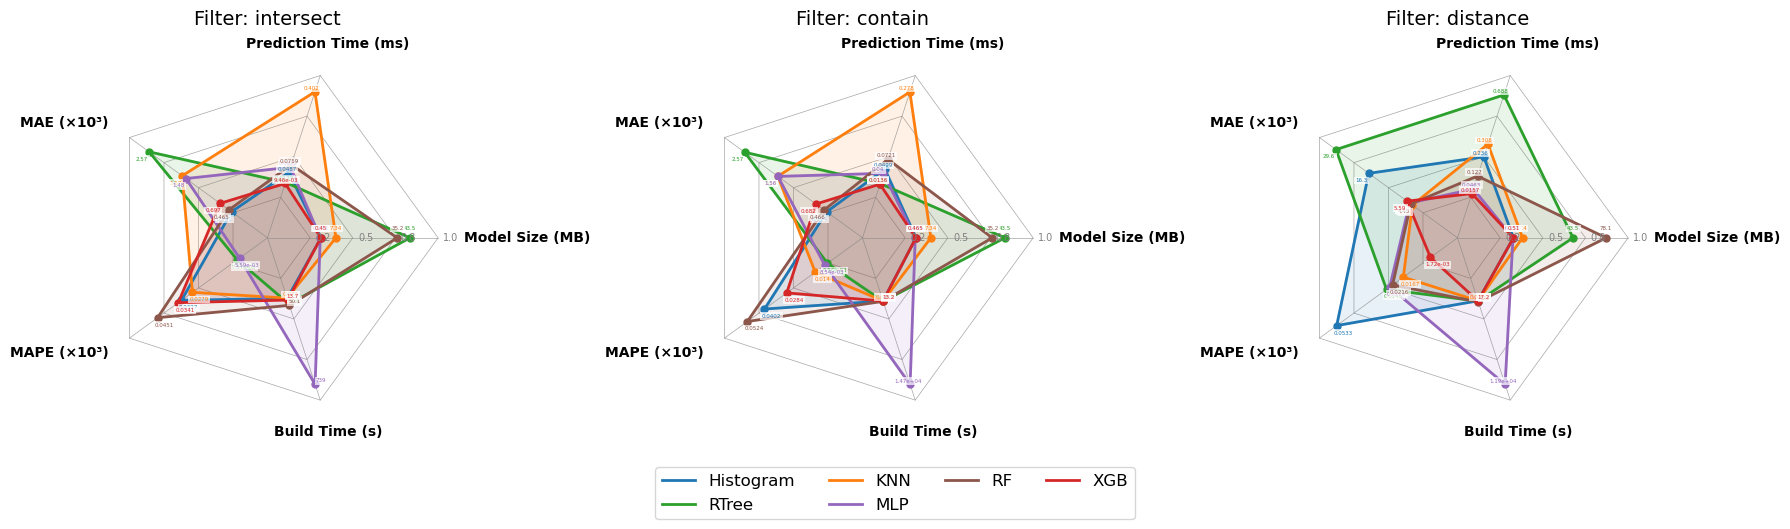

In [15]:
# Create radar charts for each filter
fig, axes = plot_method_radar_comparison_filters(
    json_path='/home/adminlias/nadir/Spatial-Selectivity-Ext/analyze_results/model_comparison copy.json',
    operational_metrics=operational_metrics,
    normalization_method='zscore',
    figsize=(18, 6),  # Adjust based on how many filters you have
    save_path='small_radar_all_filters.pdf',
    datasets_to_exclude=big_datasets,
)

## Big datasets & All filters

Filter 'intersect':


,model_size_mb,avg_time_ms,mae,mape,build_time_s
Histogram,1.963314,0.114845,10418.077481,56.429061,760.714286
RTree,808.867346,0.052642,11863.586999,21.456853,758.683457
KNN,130.061406,0.715352,12670.014176,6.274110,2.847299
NN,0.235488,0.105883,13910.588055,36.124721,4913.364427
RF,471.127565,0.029601,3284.105617,34.615261,1298.450204
XGB,0.540980,0.005544,11016.545201,21.886789,78.095296


Filter 'contain':


,model_size_mb,avg_time_ms,mae,mape,build_time_s
Histogram,1.963314,0.119903,9861.483018,92.097717,760.714286
RTree,808.867346,0.059819,9870.251527,11.940817,758.683457
KNN,130.009758,0.641725,12610.335981,3.334323,2.772173
NN,0.237640,0.060130,13507.688886,34.233222,122654.432244
RF,465.591072,0.029719,3267.239309,44.995801,1336.126784
XGB,0.566956,0.007822,10446.310372,25.697906,95.119331


Filter 'distance':


,model_size_mb,avg_time_ms,mae,mape,build_time_s
Histogram,1.963314,0.759519,1.211792e+07,631.984990,760.714286
RTree,808.867346,5.760569,1.600420e+05,27.706669,758.683457
KNN,137.467756,0.520845,3.102455e+04,45.096000,3.131184
NN,0.261668,0.066890,5.627003e+04,6.094811,129429.645747
RF,1000.617665,0.052710,3.199498e+04,28.880239,2718.339705
XGB,0.592084,0.008471,8.263007e+04,15.054356,139.343057


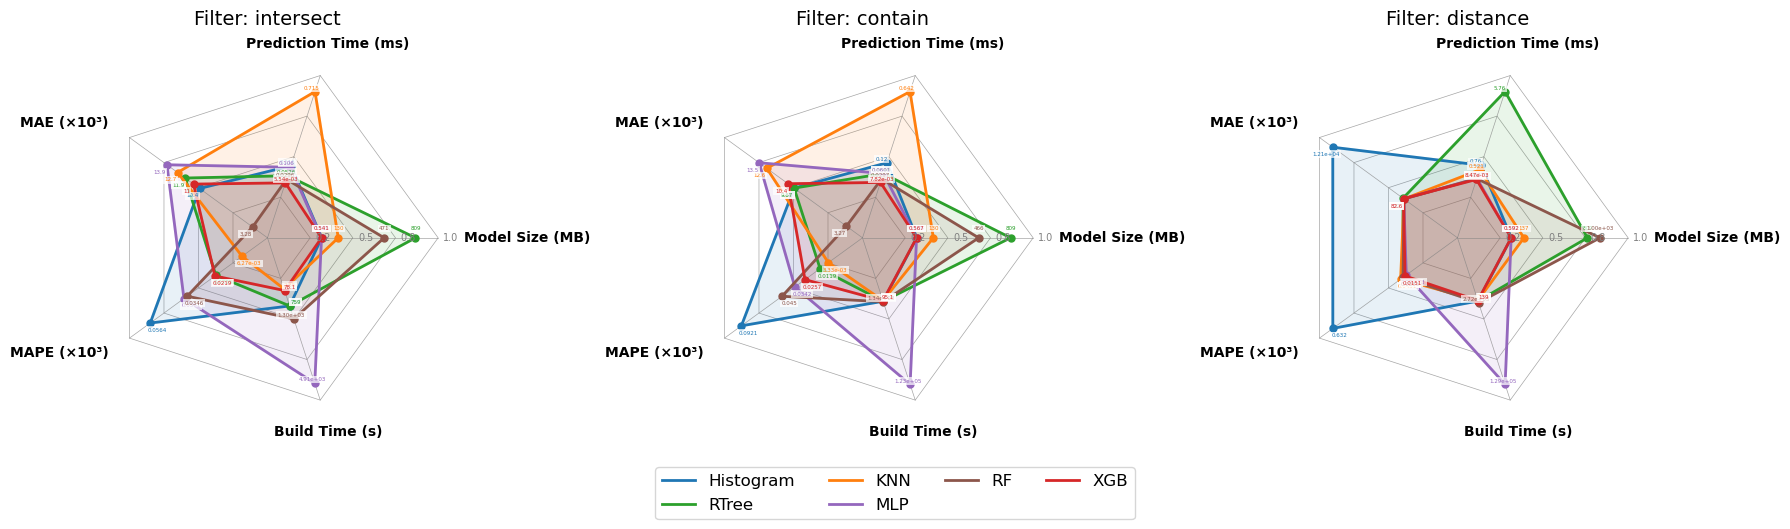

In [16]:
# Create radar charts for each filter
fig, axes = plot_method_radar_comparison_filters(
    json_path='/home/adminlias/nadir/Spatial-Selectivity-Ext/analyze_results/model_comparison copy.json',
    operational_metrics=operational_metrics,
    normalization_method='zscore',
    figsize=(18, 6),  # Adjust based on how many filters you have
    save_path='big_radar_all_filters.pdf',
    datasets_to_exclude=small_datasets,
)

## All datasets & All filters

Filter 'intersect':


,model_size_mb,avg_time_ms,mae,mape,build_time_s
Histogram,1.242354,0.081791,5404.752779,44.552866,381.285750
RTree,426.192413,0.033194,7219.208762,14.261547,399.880119
KNN,68.702764,0.558751,7117.794351,17.110651,1.462159
NN,0.189622,0.086563,7694.544302,20.857760,2826.393637
RF,253.157401,0.052739,1874.476177,39.858547,674.267655
XGB,0.495723,0.007504,5856.819437,28.006078,45.891539


Filter 'contain':


,model_size_mb,avg_time_ms,mae,mape,build_time_s
Histogram,1.242354,0.084897,5127.554011,66.137690,381.285750
RTree,426.192413,0.037516,6221.865633,9.398489,399.880119
KNN,68.676921,0.459641,7087.909611,8.680778,1.422126
NN,0.190916,0.050085,7535.066332,21.388381,68679.178430
RF,250.399186,0.050919,1866.868261,48.684947,692.941112
XGB,0.515915,0.010689,5564.273536,27.028817,54.171642


Filter 'distance':


,model_size_mb,avg_time_ms,mae,mape,build_time_s
Histogram,1.242354,0.497880,6.067137e+06,342.634790,381.285750
RTree,426.192413,3.224344,9.481864e+04,25.990274,399.880119
KNN,72.433167,0.414181,1.749366e+04,30.894279,1.602684
NN,0.209255,0.056593,3.054809e+04,14.481342,70664.986062
RF,539.337710,0.089921,1.822450e+04,25.237608,1420.392331
XGB,0.550866,0.012100,4.411149e+04,8.388810,78.293586


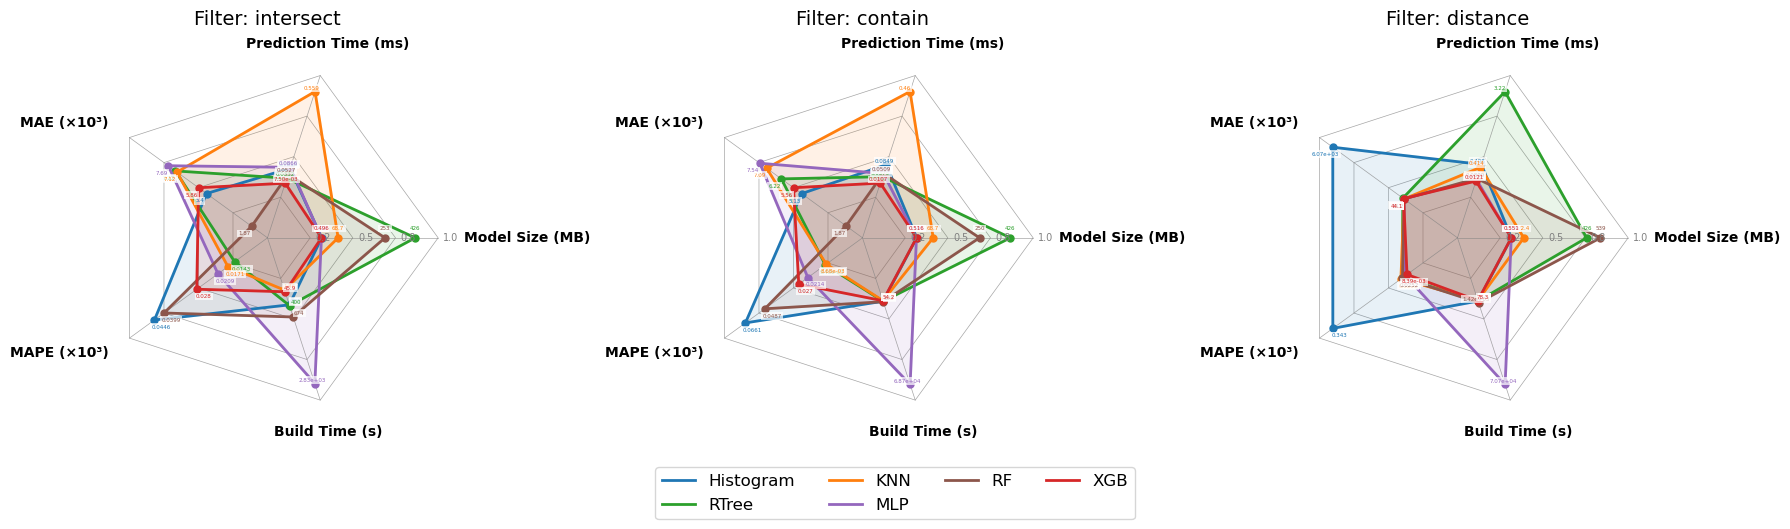

In [17]:
# Create radar charts for each filter
fig, axes = plot_method_radar_comparison_filters(
    json_path='/home/adminlias/nadir/Spatial-Selectivity-Ext/analyze_results/model_comparison copy.json',
    operational_metrics=operational_metrics,
    normalization_method='zscore',
    figsize=(18, 6),  # Adjust based on how many filters you have
    save_path='radar_all_filters.pdf',
)

# Separated Figures (1 in 1 -> single)

In [18]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from matplotlib.patches import Polygon

def plot_method_radar_comparison_filters(json_path, operational_metrics, figsize=(8, 8), 
                                       title=None, save_dir=None, metric_display_names=None,
                                       normalization_method='mad', datasets_to_exclude=set([])):
    """
    Create radar charts comparing methods across operational metrics with robust scaling,
    creating a separate figure for each filter.
    
    Args:
        json_path: Path to JSON file containing performance metrics
        operational_metrics: List of metrics to use as radar axes (e.g., ['build_time_s', 'model_size_mb'])
        figsize: Figure size for each individual figure
        title: Custom title template (can include {filter_name} placeholder)
        save_dir: Directory to save the figures
        metric_display_names: Dictionary mapping metric names to display names
        normalization_method: Method for normalizing values ('mad', 'minmax', or 'zscore')
        
    Returns:
        List of matplotlib Figures
    """
    # Validate normalization method
    if normalization_method not in ['mad', 'minmax', 'zscore']:
        raise ValueError("normalization_method must be one of: 'mad', 'minmax', 'zscore'")
    
    # Define which metrics have "smaller is better" property
    smaller_is_better = {
        'build_time_s': True,
        'avg_time_ms': True,
        'model_size_mb': True,
        'mae': True, 
        'mape': True,
    }
    
    # Define display names if not provided (with MAE and MAPE shown as x10^3)
    if metric_display_names is None:
        metric_display_names = {
            'build_time_s': 'Build Time (s)',
            'avg_time_ms': 'Prediction Time (ms)',
            'model_size_mb': 'Model Size (MB)',
            'mae': 'MAE (×10³)',
            'mape': 'MAPE (×10³)',
        }
    
    # Fill in any missing display names
    for metric in operational_metrics:
        if metric not in metric_display_names:
            metric_display_names[metric] = metric
    
    # Load the JSON data
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Reorganize data by filter then by model
    filters_data = {}
    
    # Process all datasets
    for dataset, models in data.items():
        if dataset in datasets_to_exclude:
            continue
        for model, filters in models.items():
            if model == 'DT': 
                continue
            for filter_name, metrics in filters.items():
                if filter_name not in filters_data:
                    filters_data[filter_name] = {}
                
                if model not in filters_data[filter_name]:
                    filters_data[filter_name][model] = {metric: [] for metric in operational_metrics}
                
                # Collect metrics for this model and filter
                for metric in operational_metrics:
                    if metric in metrics:
                        filters_data[filter_name][model][metric].append(metrics[metric])
    
    # Calculate average metrics for each filter and model
    filter_model_metrics = {}
    
    for filter_name, models in filters_data.items():
        filter_model_metrics[filter_name] = {}
        
        for model, metrics in models.items():
            filter_model_metrics[filter_name][model] = {}
            
            for metric, values in metrics.items():
                if values:  # Check if there are any values
                    filter_model_metrics[filter_name][model][metric] = np.mean(values)
                else:
                    filter_model_metrics[filter_name][model][metric] = np.nan
    
    # Get all filters and models
    all_filters = list(filter_model_metrics.keys())
    
    # Get all unique models across all filters for the legend
    all_models = set()
    for filter_data in filter_model_metrics.values():
        all_models.update(filter_data.keys())
    all_models = list(all_models)
    
    # Create color palette for all models
    palette = sns.color_palette('tab10', n_colors=len(all_models))
    model_colors = {model: palette[i] for i, model in enumerate(all_models)}
    
    # Create a figure for each filter
    figures = []

    
    # Process each filter
    for filter_name in all_filters:
        # Create a new figure for this filter
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        figures.append(fig)
        
        # Get data for this filter
        models_data = filter_model_metrics[filter_name]
        
        # Convert to DataFrame
        data_df = pd.DataFrame.from_dict(models_data, orient='index')
        raw_data = models_data.copy()
        
        # Store normalization info for this filter
        normalization_info = {}
        
        # Normalize each metric
        normalized_df = data_df.copy()
        
        for metric in operational_metrics:
            # Skip if metric not present
            if metric not in data_df.columns:
                continue
            
            # Get metric values
            values = data_df[metric].values
            
            # Skip if only one distinct value or all NaN
            if len(np.unique(values[~np.isnan(values)])) <= 1:
                normalized_df[metric] = 0.5
                # Store min/max as same value for inverse mapping
                normalization_info[metric] = {
                    'type': 'constant',
                    'value': values[~np.isnan(values)][0] if any(~np.isnan(values)) else 0
                }
                continue
            
            # Handle NaNs by replacing with the mean
            if np.any(np.isnan(values)):
                mean_val = np.nanmean(values)
                values = np.nan_to_num(values, nan=mean_val)
                data_df[metric] = values  # Update DataFrame
            
            # Store min/max for this metric
            min_val = np.min(values)
            max_val = np.max(values)
            
            if normalization_method == 'mad':
                # Use robust scaling with median absolute deviation
                median_val = np.median(values)
                mad = np.median(np.abs(values - median_val))
                
                if mad > 0:
                    # Scale using MAD
                    normalized = (values - median_val) / (1.4826 * mad)
                    
                    # Convert to 0-1 range using sigmoid function
                    normalized = 1 / (1 + np.exp(-normalized))
                    
                    # Store normalization parameters
                    normalization_info[metric] = {
                        'type': 'mad_sigmoid',
                        'median': median_val,
                        'mad': mad
                    }
                else:
                    # If MAD is 0, fall back to min-max scaling
                    if max_val > min_val:
                        normalized = (values - min_val) / (max_val - min_val)
                    else:
                        normalized = np.ones_like(values) * 0.5
                        
                    # Store normalization parameters
                    normalization_info[metric] = {
                        'type': 'minmax',
                        'min': min_val,
                        'max': max_val
                    }
                    
            elif normalization_method == 'minmax':
                # Use min-max scaling
                if max_val > min_val:
                    normalized = (values - min_val) / (max_val - min_val)
                else:
                    normalized = np.ones_like(values) * 0.5
                    
                # Store normalization parameters
                normalization_info[metric] = {
                    'type': 'minmax',
                    'min': min_val,
                    'max': max_val
                }
                    
            elif normalization_method == 'zscore':
                # Use Z-score normalization
                mean_val = np.mean(values)
                std_val = np.std(values)
                
                if std_val > 0:
                    # Z-score: (x - μ) / σ
                    z_scores = (values - mean_val) / std_val
                    
                    # Convert to 0-1 range using sigmoid function
                    normalized = 1 / (1 + np.exp(-z_scores))
                    
                    # Store normalization parameters
                    normalization_info[metric] = {
                        'type': 'zscore_sigmoid',
                        'mean': mean_val,
                        'std': std_val
                    }
                else:
                    # If std is 0, all values are the same
                    normalized = np.ones_like(values) * 0.5
                    print(f"Warning: Standard deviation is 0 for metric '{metric}', using constant value.")
                    
                    # Store normalization parameters
                    normalization_info[metric] = {
                        'type': 'constant',
                        'value': mean_val
                    }
            
            normalized_df[metric] = normalized

        print(f"Filter '{filter_name}':")
        display(data_df)
        
        # Number of metrics (angles/axes)
        N = len(operational_metrics)
        
        # Angles for each metric (in radians)
        angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
        
        # Create labels with direction indicators (↑/↓) and display names
        labels = []
        for metric in operational_metrics:
            display_name = metric_display_names[metric]
            if smaller_is_better.get(metric, True):
                labels.append(f"{display_name}")  # Down arrow for "smaller is better"
            else:
                labels.append(f"{display_name}")  # Up arrow for "bigger is better"
        
        # Convert to cartesian coordinates
        def polar_to_cartesian(r, theta):
            return r * np.cos(theta), r * np.sin(theta)
        
        # Define grid levels in normalized space
        grid_levels = [0.25, 0.5, 0.75, 1.0]
        
        # Draw grid polygons
        for level in grid_levels:
            # Get points on polygon for this level
            polygon_coords = []
            for angle in angles:
                x, y = polar_to_cartesian(level, angle)
                polygon_coords.append((x, y))
            
            # Create and plot the polygon
            poly = Polygon(polygon_coords, closed=True, fill=False, 
                          edgecolor='gray', linewidth=0.5, alpha=0.7)
            ax.add_patch(poly)
            
            # Add text label for the grid level at the first axis
            if level > 0:  # Skip the center point
                label_x, label_y = polar_to_cartesian(level, angles[0])
                # Position text slightly to the right of the axis
                text_x = label_x + 0.03
                text_y = label_y
                ax.text(text_x, text_y, f"{level:.1f}", 
                        ha='left', va='center', fontsize=7, color='gray')
        
        # Draw radial lines from center to each metric
        for j, angle in enumerate(angles):
            metric = operational_metrics[j % len(operational_metrics)]  # Ensure we don't go out of bounds
            x_end, y_end = polar_to_cartesian(1.0, angle)
            ax.plot([0, x_end], [0, y_end], '-', color='gray', linewidth=0.5, alpha=0.7)
            
            # Position the metric labels slightly outside the polygon
            label_x, label_y = polar_to_cartesian(1.15, angle)
            ha = 'left' if label_x >= 0 else 'right'
            va = 'center'
            # Adjust for labels near the top or bottom
            if abs(label_y) > 0.85:
                va = 'top' if label_y < 0 else 'bottom'
                ha = 'center'
            
            ax.text(label_x, label_y, labels[j % len(labels)], ha=ha, va=va, fontsize=10, weight='bold')
        
        # Add colored lines for each model
        models = list(models_data.keys())
        legend_handles = []
        legend_labels = []
        
        for j, model in enumerate(models):
            if model not in data_df.index:
                continue
                
            color = model_colors[model]
            
            # Get normalized values and convert to cartesian coordinates
            values = []
            for metric in operational_metrics:
                if metric in normalized_df.columns and model in normalized_df.index:
                    values.append(normalized_df.loc[model, metric])
                else:
                    values.append(np.nan)
            
            polygon_coords = []
            data_points = []
            
            for k, angle in enumerate(angles):
                if k >= len(values):
                    continue
                    
                metric = operational_metrics[k]
                norm_value = values[k]
                
                if np.isnan(norm_value):
                    continue
                    
                raw_value = data_df.loc[model, metric]
                
                # Scale MAE and MAPE by 1000 for display
                display_value = raw_value
                if metric in ['mae', 'mape']:
                    display_value = raw_value / 1000
                
                x, y = polar_to_cartesian(norm_value, angle)
                polygon_coords.append((x, y))
                data_points.append((x, y, display_value, angle, metric))
            
            if polygon_coords:
                # Create and plot the polygon for this method
                poly = Polygon(polygon_coords, closed=True, alpha=0.1, 
                              edgecolor=color, facecolor=color, linewidth=2)
                ax.add_patch(poly)
                
                # Plot the polygon vertices
                xs = [p[0] for p in polygon_coords]
                ys = [p[1] for p in polygon_coords]
                
                # If we have enough points to close the polygon
                if len(xs) > 2:
                    xs.append(xs[0])  # Close the polygon
                    ys.append(ys[0])
                
                # Plot the line
                line = ax.plot(xs, ys, '-', color=color, linewidth=2)
                legend_handles.append(line[0])
                legend_labels.append(model if model != 'NN' else 'MLP')
                
                # Add data point markers
                for x, y, display_value, angle, metric in data_points:
                    ax.plot(x, y, 'o', color=color, markersize=5)
                    
                    # Format the value based on its magnitude and metric
                    if abs(display_value) < 0.01 or abs(display_value) > 1000:
                        value_text = f"{display_value:.2e}"
                    else:
                        value_text = f"{display_value:.3g}"
                    
                    # Position the text based on the angle
                    # Adjust position to prevent overlap
                    offset = 0.07
                    perp_angle = angle + np.pi/2  # Perpendicular to the radial line
                    
                    # Text position with offset perpendicular to radial line
                    text_x = x + offset * np.cos(perp_angle)
                    text_y = y + offset * np.sin(perp_angle)
                    
                    # Adjust alignment based on position in the chart
                    ha = 'center'
                    va = 'center'
                    if abs(np.cos(angle)) > 0.7:  # Near horizontal axes
                        va = 'bottom' if np.cos(angle) < 0 else 'top'
                    if abs(np.sin(angle)) > 0.7:  # Near vertical axes
                        ha = 'right' if np.sin(angle) < 0 else 'left'
                    
                    # Add the value text with faint background for readability
                    ax.text(text_x, text_y, value_text,
                           ha=ha, va=va, fontsize=6, color=color,
                           bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
        
        # Add legend
        ax.legend(legend_handles, legend_labels, 
                  loc='lower center', ncol=min(len(legend_labels), 4),
                  bbox_to_anchor=(0.5, -0.15), fontsize=10)
        
        # Equal aspect ratio ensures the polygon looks regular
        ax.set_aspect('equal')
        
        # Remove the axis ticks and spines
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        # Set limits slightly larger than the outermost grid level
        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2)
        
        # Set title for this filter's figure
        if title is None:
            norm_name_map = {
                "mad": "MAD",
                "minmax": "Min-Max",
                "zscore": "Z-Score"
            }
            norm_name = norm_name_map.get(normalization_method, normalization_method.capitalize())
            filter_title = f"Filter: {filter_name}"
        else:
            filter_title = title.format(filter_name=filter_name)
            
        # ax.set_title(filter_title, fontsize=14)
        
        # Adjust layout to make room for the legend at the bottom
        plt.tight_layout(rect=[0, 0.05, 1, 0.95])
        
        # Save the figure if a save directory is provided
        if save_dir:
            # Ensure the directory exists
            os.makedirs(save_dir, exist_ok=True)
            
            # Create a valid filename from the filter name
            safe_filter_name = re.sub(r'[^a-zA-Z0-9_-]', '_', filter_name)
            save_path = os.path.join(save_dir, f"radar_chart_{safe_filter_name}.pdf")
            
            # Save the figure
            fig.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return figures

## Big datasets & Separated filters

Filter 'intersect':


,model_size_mb,avg_time_ms,mae,mape,build_time_s
Histogram,1.963314,0.114845,10418.077481,56.429061,760.714286
RTree,808.867346,0.052642,11863.586999,21.456853,758.683457
KNN,130.061406,0.715352,12670.014176,6.274110,2.847299
NN,0.235488,0.105883,13910.588055,36.124721,4913.364427
RF,471.127565,0.029601,3284.105617,34.615261,1298.450204
XGB,0.540980,0.005544,11016.545201,21.886789,78.095296


Filter 'contain':


,model_size_mb,avg_time_ms,mae,mape,build_time_s
Histogram,1.963314,0.119903,9861.483018,92.097717,760.714286
RTree,808.867346,0.059819,9870.251527,11.940817,758.683457
KNN,130.009758,0.641725,12610.335981,3.334323,2.772173
NN,0.237640,0.060130,13507.688886,34.233222,122654.432244
RF,465.591072,0.029719,3267.239309,44.995801,1336.126784
XGB,0.566956,0.007822,10446.310372,25.697906,95.119331


Filter 'distance':


,model_size_mb,avg_time_ms,mae,mape,build_time_s
Histogram,1.963314,0.759519,1.211792e+07,631.984990,760.714286
RTree,808.867346,5.760569,1.600420e+05,27.706669,758.683457
KNN,137.467756,0.520845,3.102455e+04,45.096000,3.131184
NN,0.261668,0.066890,5.627003e+04,6.094811,129429.645747
RF,1000.617665,0.052710,3.199498e+04,28.880239,2718.339705
XGB,0.592084,0.008471,8.263007e+04,15.054356,139.343057


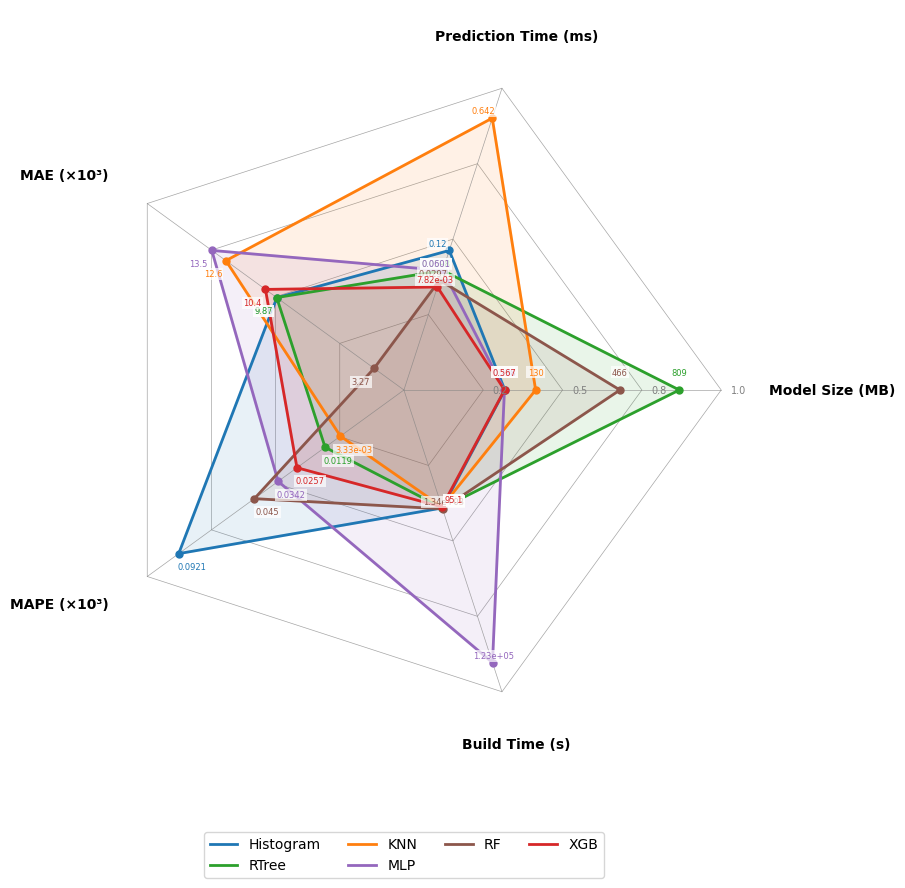

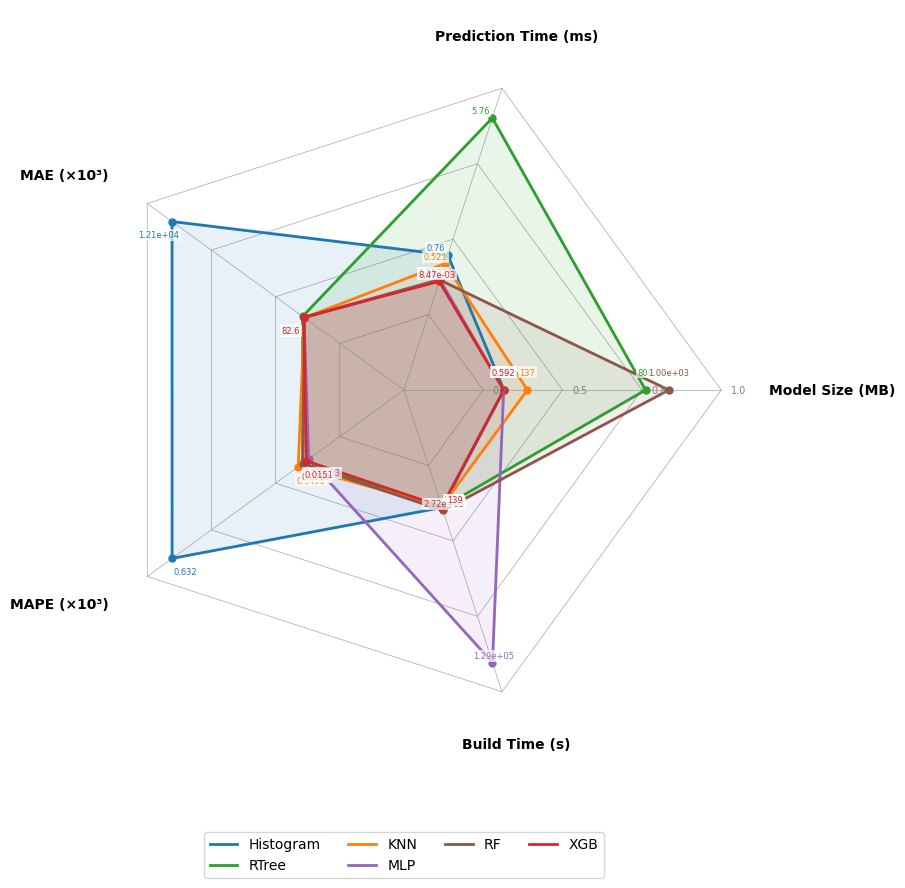

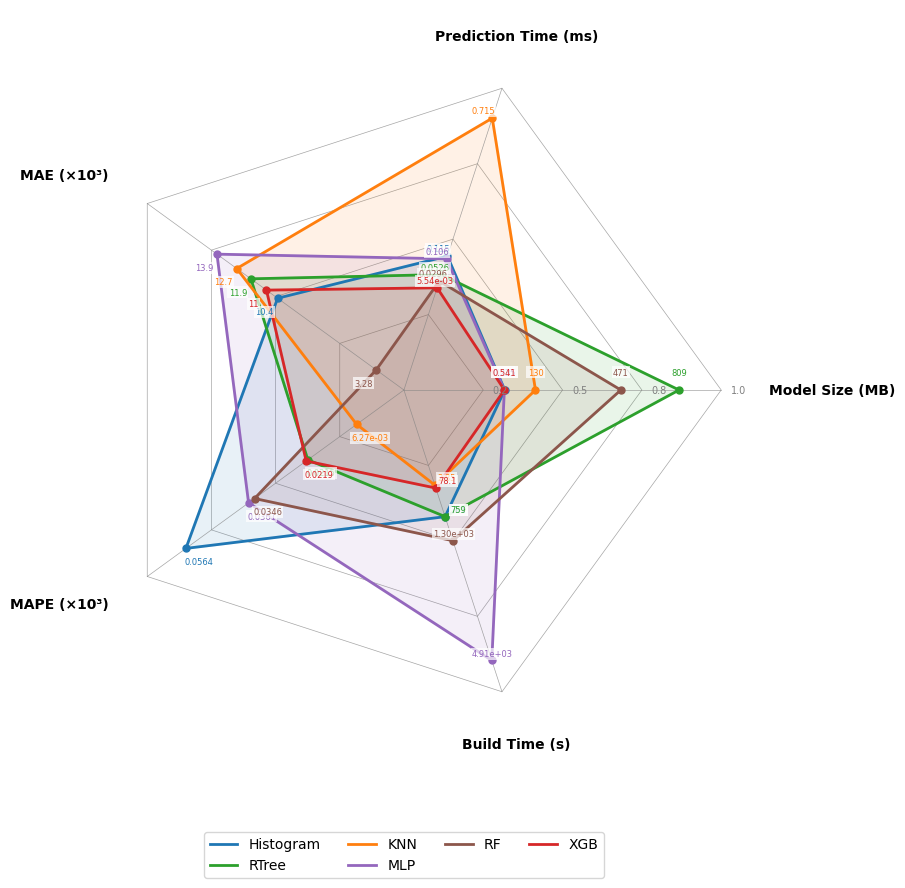

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [19]:
figures = plot_method_radar_comparison_filters(
    json_path='/home/adminlias/nadir/Spatial-Selectivity-Ext/analyze_results/model_comparison copy.json',
    operational_metrics=operational_metrics,
    normalization_method='zscore',
    figsize=(10, 10),  # Size of each individual figure
    title=None,  # Optional title template
    save_dir='big_radar_charts',  # Directory to save individual figures
    datasets_to_exclude=small_datasets
)

# If you want to show the figures (in a notebook for example)
for fig in figures:
    plt.figure(fig.number)
    plt.show()

## Small datasets & Separated filters

Filter 'intersect':


,model_size_mb,avg_time_ms,mae,mape,build_time_s
Histogram,0.521394,0.048736,391.428077,32.676672,1.857214
RTree,43.517480,0.013745,2574.830526,7.066241,41.076780
KNN,7.344122,0.402151,1565.574526,27.947191,0.077019
NN,0.143756,0.067242,1478.500549,5.590798,739.422847
RF,35.187237,0.075877,464.846736,45.101833,50.085107
XGB,0.450466,0.009464,697.093674,34.125368,13.687782


Filter 'contain':


,model_size_mb,avg_time_ms,mae,mape,build_time_s
Histogram,0.521394,0.049891,393.625005,40.177662,1.857214
RTree,43.517480,0.015214,2573.479739,6.856161,41.076780
KNN,7.344084,0.277558,1565.483241,14.027233,0.072079
NN,0.144191,0.040040,1562.443778,8.543540,14703.924617
RF,35.207300,0.072120,466.497214,52.374093,49.755441
XGB,0.464874,0.013557,682.236701,28.359728,13.223954


Filter 'distance':


,model_size_mb,avg_time_ms,mae,mape,build_time_s
Histogram,0.521394,0.236241,16349.086554,53.284590,1.857214
RTree,43.517480,0.688119,29595.289063,24.273879,41.076780
KNN,7.398578,0.307516,3962.769037,16.692557,0.074183
NN,0.156843,0.046296,4826.142301,22.867873,11900.326376
RF,78.057755,0.127131,4454.012947,21.594977,122.444956
XGB,0.509648,0.015730,5592.919711,1.723264,17.244116


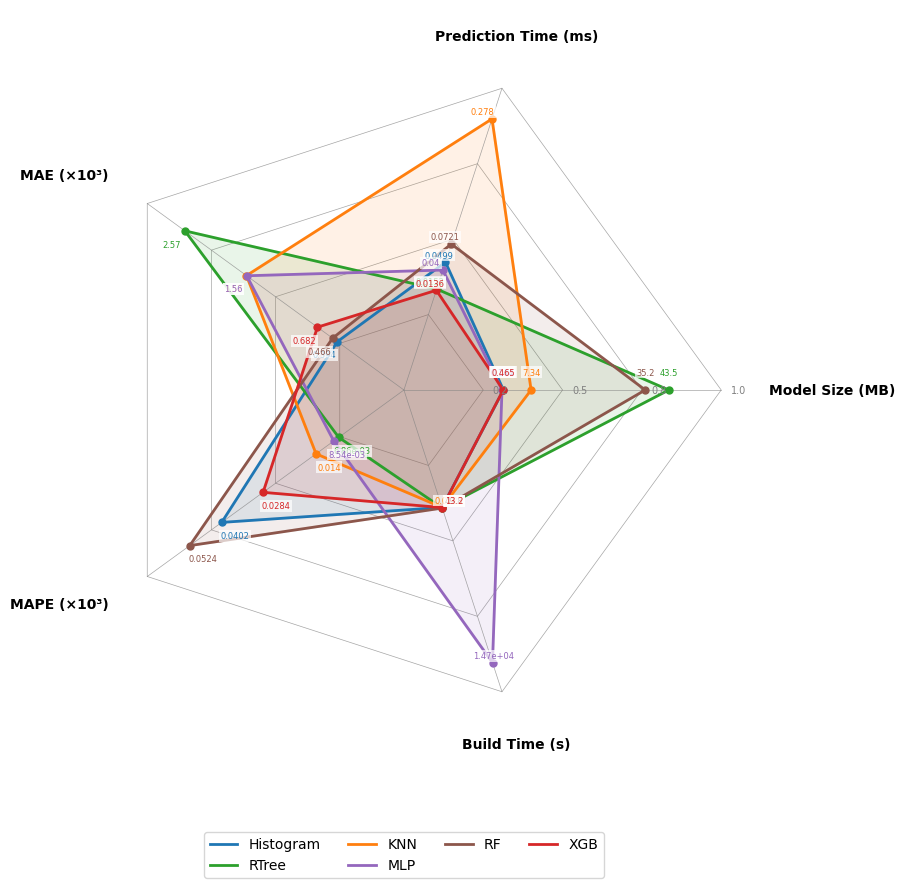

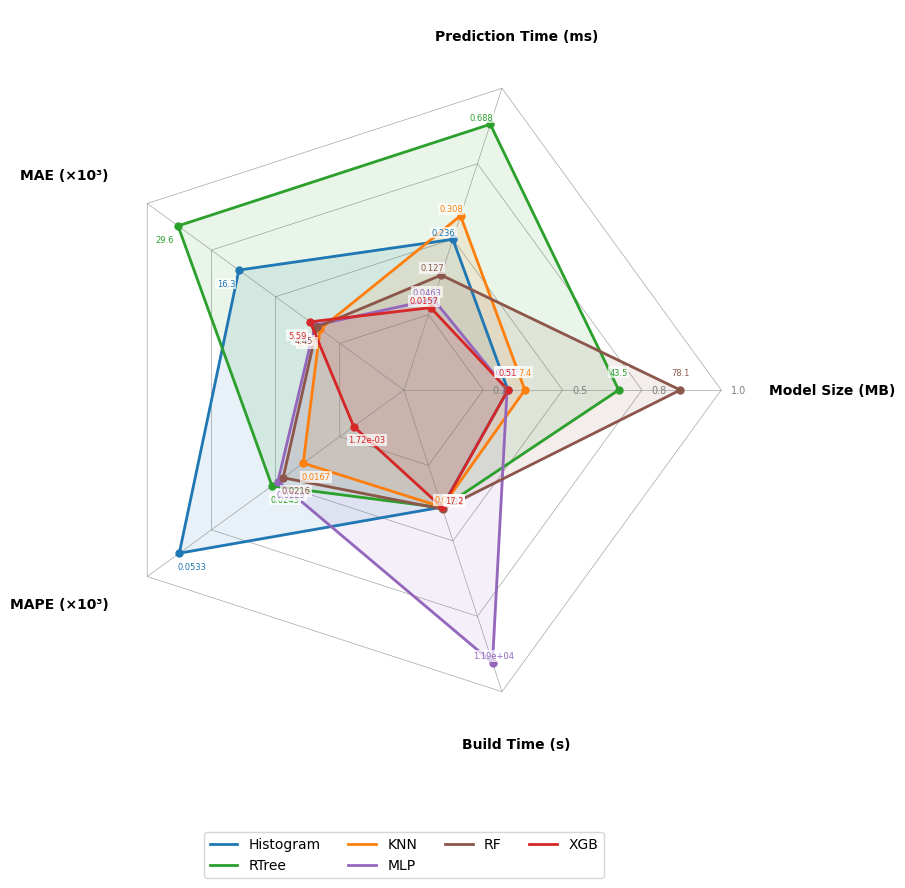

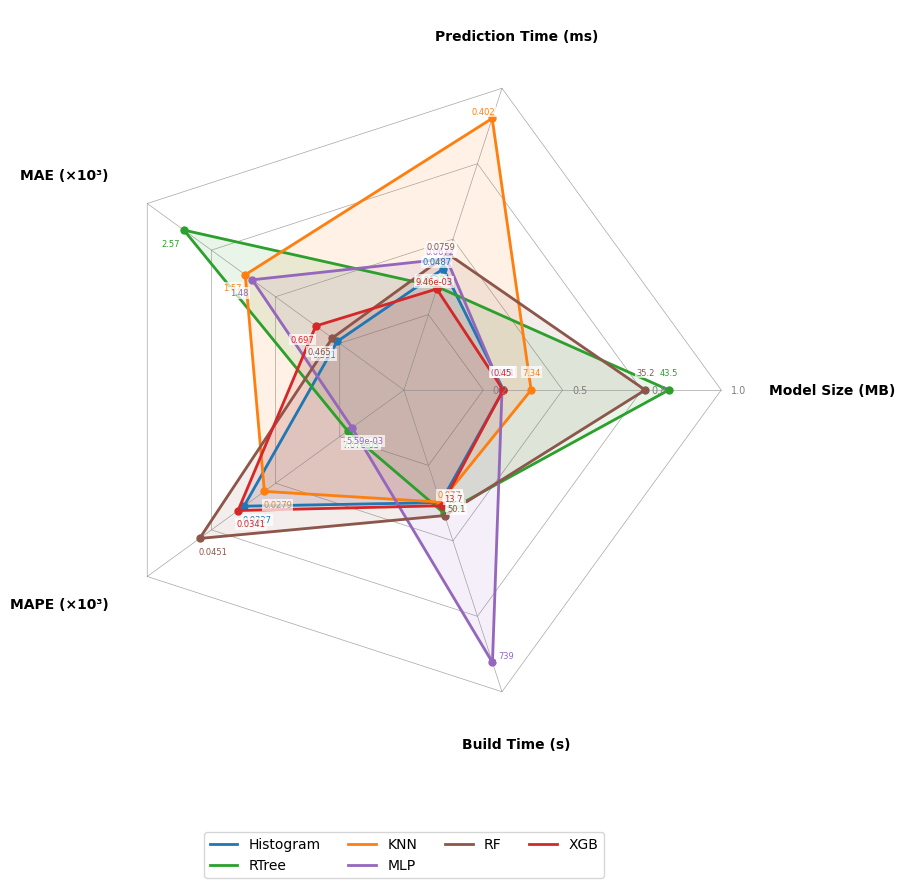

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [20]:
figures = plot_method_radar_comparison_filters(
    json_path='/home/adminlias/nadir/Spatial-Selectivity-Ext/analyze_results/model_comparison copy.json',
    operational_metrics=operational_metrics,
    normalization_method='zscore',
    figsize=(10, 10),  # Size of each individual figure
    title=None,  # Optional title template
    save_dir='small_radar_charts',  # Directory to save individual figures
    datasets_to_exclude=big_datasets
)

# If you want to show the figures (in a notebook for example)
for fig in figures:
    plt.figure(fig.number)
    plt.show()

## All datasets & Separated filters

Filter 'intersect':


,model_size_mb,avg_time_ms,mae,mape,build_time_s
Histogram,1.242354,0.081791,5404.752779,44.552866,381.285750
RTree,426.192413,0.033194,7219.208762,14.261547,399.880119
KNN,68.702764,0.558751,7117.794351,17.110651,1.462159
NN,0.189622,0.086563,7694.544302,20.857760,2826.393637
RF,253.157401,0.052739,1874.476177,39.858547,674.267655
XGB,0.495723,0.007504,5856.819437,28.006078,45.891539


Filter 'contain':


,model_size_mb,avg_time_ms,mae,mape,build_time_s
Histogram,1.242354,0.084897,5127.554011,66.137690,381.285750
RTree,426.192413,0.037516,6221.865633,9.398489,399.880119
KNN,68.676921,0.459641,7087.909611,8.680778,1.422126
NN,0.190916,0.050085,7535.066332,21.388381,68679.178430
RF,250.399186,0.050919,1866.868261,48.684947,692.941112
XGB,0.515915,0.010689,5564.273536,27.028817,54.171642


Filter 'distance':


,model_size_mb,avg_time_ms,mae,mape,build_time_s
Histogram,1.242354,0.497880,6.067137e+06,342.634790,381.285750
RTree,426.192413,3.224344,9.481864e+04,25.990274,399.880119
KNN,72.433167,0.414181,1.749366e+04,30.894279,1.602684
NN,0.209255,0.056593,3.054809e+04,14.481342,70664.986062
RF,539.337710,0.089921,1.822450e+04,25.237608,1420.392331
XGB,0.550866,0.012100,4.411149e+04,8.388810,78.293586


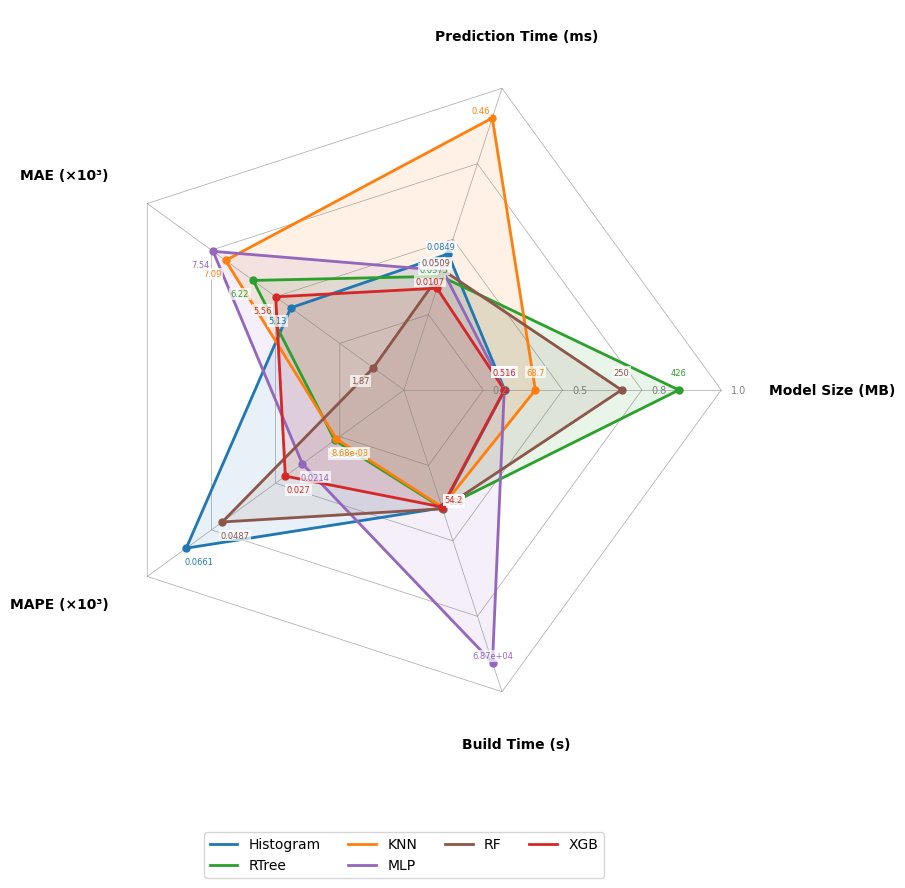

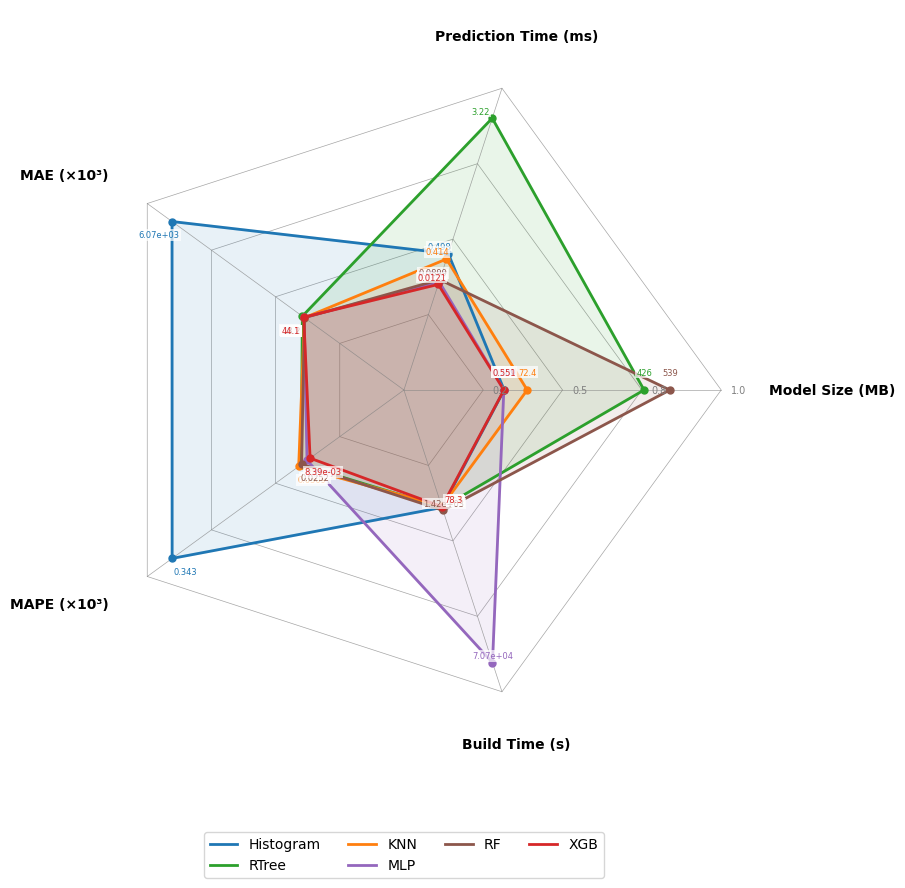

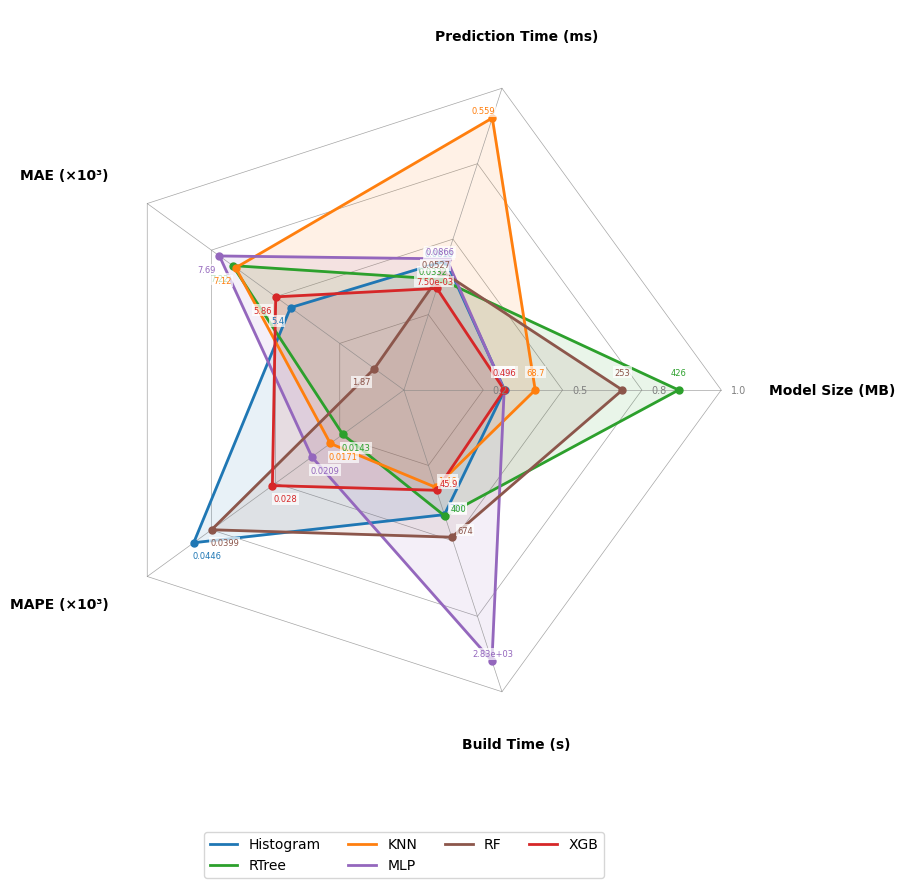

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [21]:
figures = plot_method_radar_comparison_filters(
    json_path='/home/adminlias/nadir/Spatial-Selectivity-Ext/analyze_results/model_comparison copy.json',
    operational_metrics=operational_metrics,
    normalization_method='zscore',
    figsize=(10, 10),  # Size of each individual figure
    title=None,  # Optional title template
    save_dir='all_radar_charts',  # Directory to save individual figures
)

# If you want to show the figures (in a notebook for example)
for fig in figures:
    plt.figure(fig.number)
    plt.show()